In [37]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [38]:
# Function to clean text
def clean_text(text):
    text = re.sub(r'\W', ' ', str(text))
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    return text

# Function to predict spam/ham category
def predict_spam_ham(text, model, tokenizer, max_len, label_encoder):
    cleaned_text = clean_text(text)
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    prediction = model.predict(padded_sequence)
    return label_encoder.inverse_transform(np.argmax(prediction, axis=1))[0]

# Function to plot training metrics
def plot_training_metrics(history, img_prefix='training'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f'{img_prefix}_accuracy.png')
    plt.show()

    plt.figure()
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{img_prefix}_loss.png')
    plt.show()


In [39]:

# Load the dataset
df = pd.read_csv('enron_05_17_2015_with_labels_v2.csv\enron_05_17_2015_with_labels_v2.csv', nrows=10000)

# Proceed with your processing
print(df.shape)
print(df.head())

# Combine and clean text data
df['Text'] = df['Subject'].fillna('') + ' ' + df['content'].fillna('')
df['Text'] = df['Text'].apply(clean_text)

# Encode labels
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['labeled'])

# Tokenization and Padding
MAX_WORDS = 10000
MAX_LEN = 100

# Ensure the tokenizer uses only the top 10,000 words
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df['Text'])
sequences = tokenizer.texts_to_sequences(df['Text'])

# Pad the sequences
X = pad_sequences(sequences, maxlen=MAX_LEN)

y = df['Label']


(10000, 52)
   Unnamed: 0                                     Message-ID  \
0           0  <18782981.1075855378110.JavaMail.evans@thyme>   
1           1  <15464986.1075855378456.JavaMail.evans@thyme>   
2           2  <24216240.1075855687451.JavaMail.evans@thyme>   
3           3  <13505866.1075863688222.JavaMail.evans@thyme>   
4           4  <30922949.1075863688243.JavaMail.evans@thyme>   

                  Date                                    From  \
0  2001-05-14 23:39:00  frozenset({'phillip.allen@enron.com'})   
1  2001-05-04 20:51:00  frozenset({'phillip.allen@enron.com'})   
2  2000-10-18 10:00:00  frozenset({'phillip.allen@enron.com'})   
3  2000-10-23 13:13:00  frozenset({'phillip.allen@enron.com'})   
4  2000-08-31 12:07:00  frozenset({'phillip.allen@enron.com'})   

                                       To    Subject           X-From  \
0     frozenset({'tim.belden@enron.com'})        NaN  Phillip K Allen   
1  frozenset({'john.lavorato@enron.com'})        Re:  Philli

In [40]:
# Example of adding additional features
df['Text_length'] = df['Text'].apply(len)
df['num_words'] = df['Text'].apply(lambda x: len(x.split()))
df['num_unique_words'] = df['Text'].apply(lambda x: len(set(x.split())))

# Feature Selection using TF-IDF and SelectKBest
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf_vectorizer.fit_transform(df['Text'])

additional_features = df[['Text_length', 'num_words', 'num_unique_words']].values
X = np.hstack((X_tfidf.toarray(), additional_features))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['Label'], test_size=0.2, random_state=42)

selector = SelectKBest(chi2, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)


In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D, Dense, Dropout, Flatten

# Building the model
# Assuming X_train_selected and X_test_selected are based on TF-IDF or similar and not sequences
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_selected.shape[1],)))  # Adjust input shape to match feature vector size
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Train the model
history = model.fit(X_train_selected, y_train, epochs=5, batch_size=32, validation_data=(X_test_selected, y_test))






Epoch 1/5


c:\Users\Hatim\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9771 - loss: 5.3100 - val_accuracy: 0.9975 - val_loss: 3.6517
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9955 - loss: 2.1460 - val_accuracy: 0.9975 - val_loss: 0.9645
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9969 - loss: 0.1948 - val_accuracy: 0.9975 - val_loss: 0.2098
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 1.2495 - val_accuracy: 0.9975 - val_loss: 0.4125
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9989 - loss: 0.0478 - val_accuracy: 0.9975 - val_loss: 0.0507


In [42]:
from sklearn.metrics import classification_report

# Evaluate the model
loss, accuracy = model.evaluate(X_test_selected, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Get predictions on the test set
y_pred = model.predict(X_test_selected)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure labels are properly encoded
y_test_encoded = np.array(y_test, dtype=int)
y_pred_classes_encoded = np.array(y_pred_classes, dtype=int)

# Convert the classes to string labels if they are boolean
label_names = label_encoder.classes_
if label_names.dtype == np.bool_:
    label_names = label_names.astype(str)

# Print classification report
print(classification_report(y_test_encoded, y_pred_classes_encoded, target_names=label_names))

# Example prediction (make sure to use the same type of preprocessed data as the model expects)
example_text = "Win a brand new car! Click here for details."
# Clean the text
cleaned_example_text = clean_text(example_text)

# Transform the text using the TF-IDF vectorizer
example_tfidf = tfidf_vectorizer.transform([cleaned_example_text]).toarray()

# Add the additional features
example_text_length = len(cleaned_example_text)
example_num_words = len(cleaned_example_text.split())
example_num_unique_words = len(set(cleaned_example_text.split()))

# Combine TF-IDF features with additional features
example_features = np.hstack((example_tfidf, [[example_text_length, example_num_words, example_num_unique_words]]))

# Ensure the features are selected in the same way as the training data
example_features_selected = selector.transform(example_features)

# Predict using the model
prediction = model.predict(example_features_selected)
predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])

print(f"Prediction: {predicted_label[0]}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9966 - loss: 0.0948
Test Accuracy: 99.75%
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1995
        True       0.00      0.00      0.00         5

    accuracy                           1.00      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       1.00      1.00      1.00      2000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction: False


c:\Users\Hatim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hatim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hatim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

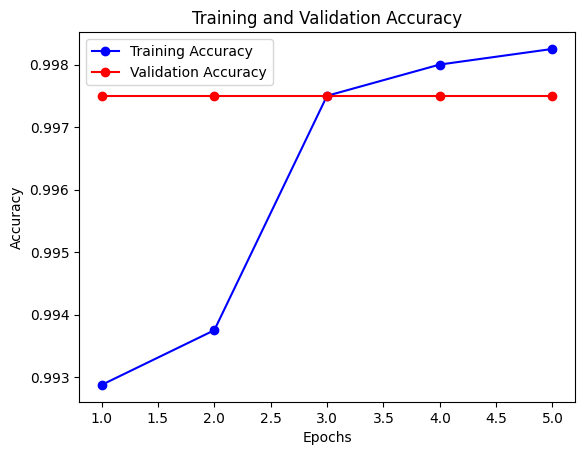

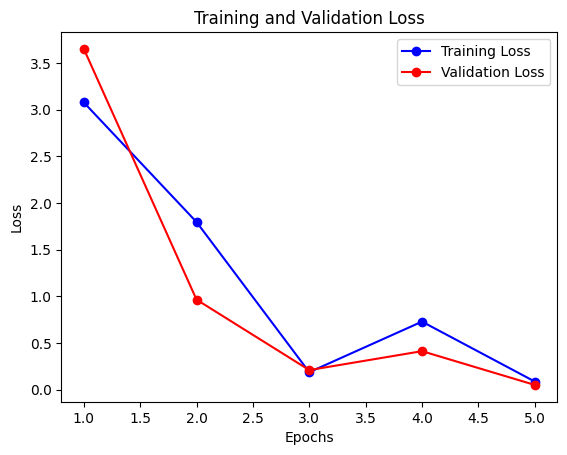

In [43]:
# Plot the training and validation metrics
plot_training_metrics(history, img_prefix='enron_spam_detection')
